Big Mart Sales Prediction


Importing Libraries

In [38]:
import kaggle as kg
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn import metrics


Data Collection and Analysis

In [2]:

# Download the dataset
os.environ['KAGGLE_USERNAME'] = 'firrex'
os.environ['KAGGLE_KEY'] = 'ce0e7c23f4f3624c6b36e0c5733d845f'

kg.api.authenticate()


In [3]:
kg.api.dataset_download_files('brijbhushannanda1979/bigmart-sales-data', path='On-Zip', unzip=True)


Dataset URL: https://www.kaggle.com/datasets/brijbhushannanda1979/bigmart-sales-data


In [4]:
#load the dataset into pandas dataframe
big_mart_data = pd.read_csv('On-Zip/Train.csv')

In [5]:
#first 5 rows of the dataframe
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
#no of rows and columns
big_mart_data.shape

(8523, 12)

In [7]:
#information about the dataset
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [8]:
#number of missing values in each column
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Categorical Features:
1. Item_Identifier
2. Item_Fat_Content
3. Item_Type
4. Outlet_Identifier
5. Outlet_Size
6. Outlet_Location_Type
7. Outlet_Type

Handling the missing Value

1. Meam
2. Mode

In [9]:
#mean value of "Item_Weight" column
big_mart_data['Item_Weight'].mean()

np.float64(12.857645184135976)

In [10]:
#fill missing values with mean value
big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean(), inplace=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_23308\3689436713.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean(), inplace=True)


In [11]:
#mode of "Outlet_Size" column
mode_of_Outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [12]:
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [13]:
missing_values = big_mart_data['Outlet_Size'].isnull()

In [14]:
print(missing_values)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [15]:
big_mart_data.loc[missing_values, 'Outlet_Size'] = big_mart_data.loc[missing_values, 'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [16]:
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [17]:
#statistical measures of the dataset
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [18]:
sns.set()

<Figure size 600x600 with 0 Axes>

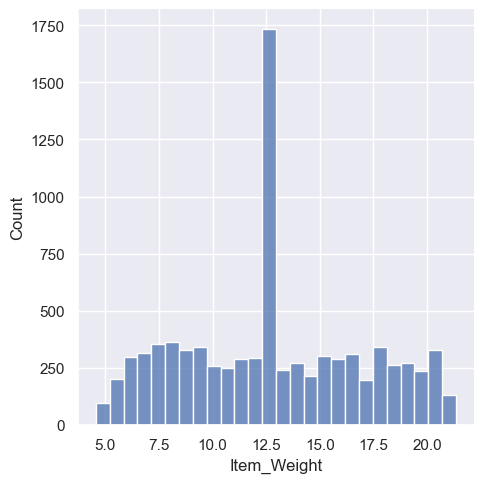

In [19]:
#item weight distribution
plt.figure(figsize=(6, 6))
sns.displot(big_mart_data['Item_Weight'])
plt.show()


<Figure size 600x600 with 0 Axes>

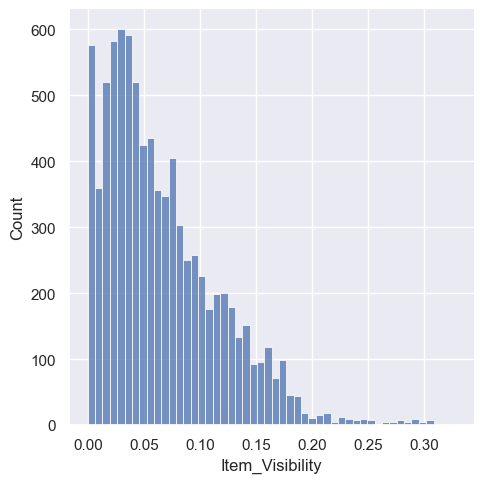

In [20]:
#item visibility distribution
plt.figure(figsize=(6, 6))
sns.displot(big_mart_data['Item_Visibility'])
plt.show()

<Figure size 600x600 with 0 Axes>

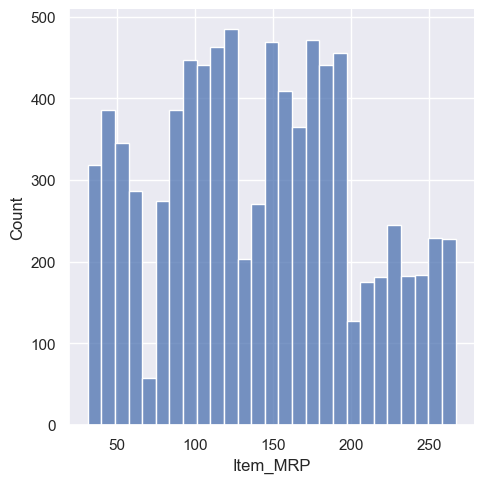

In [21]:
#item mrp distribution
plt.figure(figsize=(6, 6))
sns.displot(big_mart_data['Item_MRP'])
plt.show()


<Figure size 600x600 with 0 Axes>

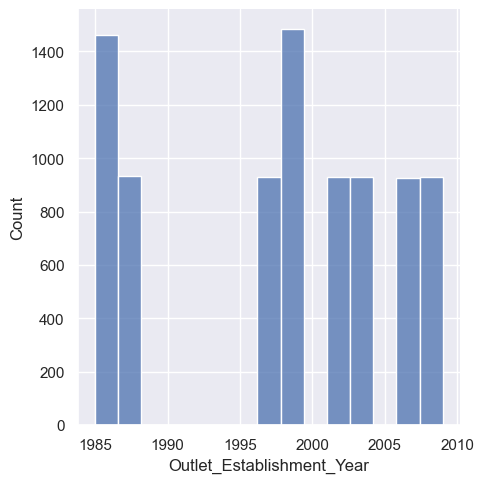

In [22]:
#outlet establishment year distribution
plt.figure(figsize=(6, 6))
sns.displot(big_mart_data['Outlet_Establishment_Year'])
plt.show()

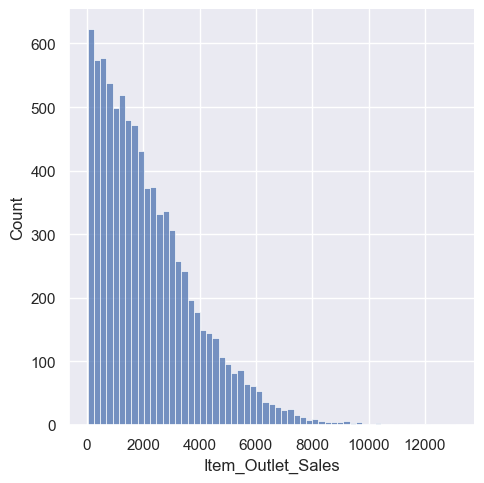

In [23]:
if 'Item_Outlet_Sales' in big_mart_data.columns:
    sns.displot(big_mart_data['Item_Outlet_Sales'])
else:
    print("Column 'Item_Outlet_Sales' does not exist in the dataframe.")


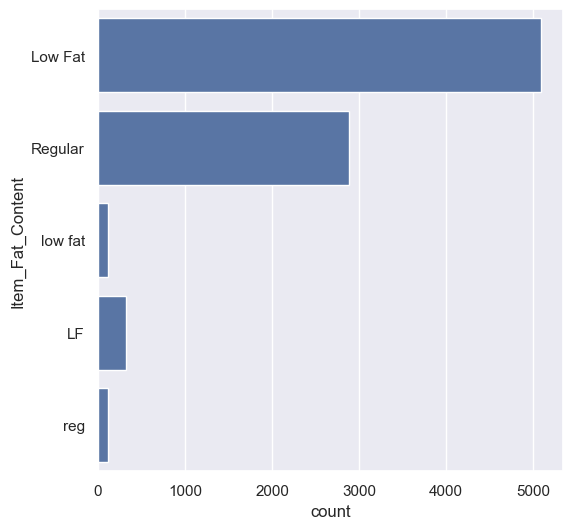

In [24]:
#item fat content distribution
plt.figure(figsize=(6, 6))
sns.countplot(big_mart_data['Item_Fat_Content'])
plt.show()


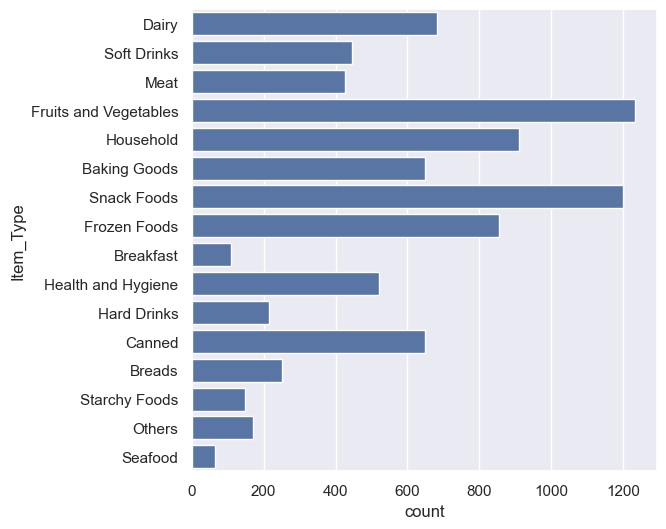

In [25]:
#item type distribution
plt.figure(figsize=(6, 6))
sns.countplot(big_mart_data['Item_Type'])
plt.show()

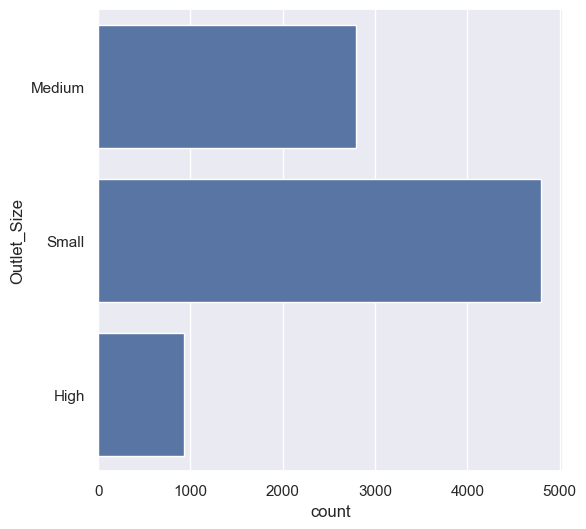

In [26]:
#outlet size distribution
plt.figure(figsize=(6, 6))
sns.countplot(big_mart_data['Outlet_Size'])
plt.show()


Data Preprocessing

In [27]:
big_mart_data['Item_Fat_Content'] = big_mart_data['Item_Fat_Content'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'}, inplace=False)


Label Encoding

In [28]:
Encoder = LabelEncoder()

In [29]:
big_mart_data['Item_Identifier'] = Encoder.fit_transform(big_mart_data['Item_Identifier'])

big_mart_data['Item_Fat_Content'] = Encoder.fit_transform(big_mart_data['Item_Fat_Content'])

big_mart_data['Item_Type'] = Encoder.fit_transform(big_mart_data['Item_Type'])
big_mart_data['Outlet_Identifier'] = Encoder.fit_transform(big_mart_data['Outlet_Identifier'])
big_mart_data['Outlet_Size'] = Encoder.fit_transform(big_mart_data['Outlet_Size'])
big_mart_data['Outlet_Location_Type'] = Encoder.fit_transform(big_mart_data['Outlet_Location_Type'])
big_mart_data['Outlet_Type'] = Encoder.fit_transform(big_mart_data['Outlet_Type'])


In [30]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


Splitting the data features and target

In [31]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
Y = big_mart_data['Item_Outlet_Sales']

train test split

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2,shuffle= True, random_state=2)


In [33]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


Model Training
XGBoost Regressor

In [34]:
regressor = XGBRegressor()

In [35]:
regressor.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

model evaluation

In [36]:
#prediction on training data
train_prediction = regressor.predict(X_train)
accuracy_train = metrics.r2_score(Y_train, train_prediction)
print('R2 value of train data:', accuracy_train)

R2 value of train data: 0.8762174618111388


In [37]:
#prediction on test data
test_prediction = regressor.predict(X_test)
accuracy_test = metrics.r2_score(Y_test, test_prediction)
print('R2 value of test data:', accuracy_test)


R2 value of test data: 0.5017253991620692
